# 🤖 IoT Security Platform - ML Model Training

**Author:** Wafaa EL HADCHI  
**Date:** November 2025  
**Goal:** Train Isolation Forest for anomaly detection

---

## 1️⃣ Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, precision_score, recall_score, f1_score
)
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✅ All libraries imported!")

✅ All libraries imported!


## 2️⃣ Load Preprocessed Data

In [3]:
# Load training and test data
X_train = pd.read_csv('../data/X_train_scaled.csv')
X_test = pd.read_csv('../data/X_test_scaled.csv')
y_train = pd.read_csv('../data/y_train.csv')['label']
y_test = pd.read_csv('../data/y_test.csv')['label']

print("📊 Data loaded successfully!")
print(f"   Training set: {X_train.shape}")
print(f"   Test set: {X_test.shape}")
print(f"\n   Features: {list(X_train.columns)}")

📊 Data loaded successfully!
   Training set: (8000, 13)
   Test set: (2000, 13)

   Features: ['cpu_usage', 'memory_usage', 'network_in_kb', 'network_out_kb', 'packet_rate', 'avg_response_time_ms', 'service_access_count', 'failed_auth_attempts', 'is_encrypted', 'geo_location_variation', 'network_total', 'network_ratio', 'cpu_memory_product']


## 3️⃣ Check Label Distribution

In [4]:
print("🏷️  Training set labels:")
print(y_train.value_counts())
print(f"\n   Normal samples: {(y_train == 'Normal').sum():,}")
print(f"   Anomaly samples: {(y_train != 'Normal').sum():,}")
print(f"   Contamination: {(y_train != 'Normal').sum() / len(y_train):.2%}")

🏷️  Training set labels:
label
Normal               6358
Anomaly_DoS           798
Anomaly_Injection     450
Anomaly_Spoofing      394
Name: count, dtype: int64

   Normal samples: 6,358
   Anomaly samples: 1,642
   Contamination: 20.52%


## 4️⃣ Prepare Training Data (Normal Only)

In [5]:
# Isolation Forest is UNSUPERVISED - train on normal data only
X_train_normal = X_train[y_train == 'Normal']

print(f"🔒 Training on NORMAL data only:")
print(f"   Samples: {len(X_train_normal):,}")
print(f"   Shape: {X_train_normal.shape}")
print(f"\n   This teaches the model what 'NORMAL' looks like.")
print(f"   Then it can detect ANYTHING that deviates!")

🔒 Training on NORMAL data only:
   Samples: 6,358
   Shape: (6358, 13)

   This teaches the model what 'NORMAL' looks like.
   Then it can detect ANYTHING that deviates!


## 5️⃣ Train Isolation Forest

In [6]:
%%time

print("🌲 Training Isolation Forest...\n")
print("   Hyperparameters:")
print("   - contamination: 0.21 (expect 21% anomalies)")
print("   - n_estimators: 100 (decision trees)")
print("   - max_samples: auto")
print("   - random_state: 42")
print("\n   Training...\n")

# Initialize and train
iso_forest = IsolationForest(
    contamination=0.21,      # Based on dataset (21% anomalies)
    n_estimators=100,        # 100 decision trees
    max_samples='auto',      # Automatic sample size
    random_state=42,         # Reproducibility
    n_jobs=-1,               # Use all CPU cores
    verbose=0
)

iso_forest.fit(X_train_normal)

print("\n✅ Training complete!")

🌲 Training Isolation Forest...

   Hyperparameters:
   - contamination: 0.21 (expect 21% anomalies)
   - n_estimators: 100 (decision trees)
   - max_samples: auto
   - random_state: 42

   Training...


✅ Training complete!
CPU times: total: 391 ms
Wall time: 384 ms


## 6️⃣ Make Predictions

In [7]:
# Predict on test set
print("🔮 Making predictions on test set...")

y_pred = iso_forest.predict(X_test)  # -1 = anomaly, 1 = normal
y_pred_labels = ['Anomaly' if p == -1 else 'Normal' for p in y_pred]

# Get anomaly scores (lower = more anomalous)
anomaly_scores = iso_forest.decision_function(X_test)

print(f"✅ Predicted {len(y_pred):,} samples")
print(f"\n   Predicted as Normal: {sum(y_pred == 1):,}")
print(f"   Predicted as Anomaly: {sum(y_pred == -1):,}")

🔮 Making predictions on test set...
✅ Predicted 2,000 samples

   Predicted as Normal: 1,389
   Predicted as Anomaly: 611


## 7️⃣ Evaluate Performance

In [8]:
# Convert multi-class labels to binary (Normal vs Anomaly)
y_test_binary = ['Normal' if label == 'Normal' else 'Anomaly' for label in y_test]

# Calculate metrics
accuracy = accuracy_score(y_test_binary, y_pred_labels)
precision = precision_score(y_test_binary, y_pred_labels, pos_label='Anomaly')
recall = recall_score(y_test_binary, y_pred_labels, pos_label='Anomaly')
f1 = f1_score(y_test_binary, y_pred_labels, pos_label='Anomaly')

print("="*80)
print("📊 MODEL PERFORMANCE METRICS")
print("="*80)
print(f"\n   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"   Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"   F1-Score:  {f1:.4f} ({f1*100:.2f}%)")

# Verdict
print("\n🎯 VERDICT:")
if accuracy >= 0.95:
    print("   🌟 EXCELLENT! Model is production-ready!")
elif accuracy >= 0.90:
    print("   ✅ GREAT! Model performs very well!")
elif accuracy >= 0.85:
    print("   ✅ GOOD! Model is acceptable!")
else:
    print("   ⚠️  FAIR - Consider more feature engineering")

📊 MODEL PERFORMANCE METRICS

   Accuracy:  0.7545 (75.45%)
   Precision: 0.4337 (43.37%)
   Recall:    0.6463 (64.63%)
   F1-Score:  0.5191 (51.91%)

🎯 VERDICT:
   ⚠️  FAIR - Consider more feature engineering


## 8️⃣ Confusion Matrix

🔢 CONFUSION MATRIX:
                Predicted Normal  Predicted Anomaly
Actual Normal               1244                346
Actual Anomaly               145                265

   True Negatives (TN):  1,244 ✅ (correctly identified normal)
   False Positives (FP): 346 ❌ (normal flagged as anomaly)
   False Negatives (FN): 145 ❌ (missed anomalies)
   True Positives (TP):  265 ✅ (correctly detected anomalies)

   False Positive Rate: 21.76%
   False Negative Rate: 35.37%


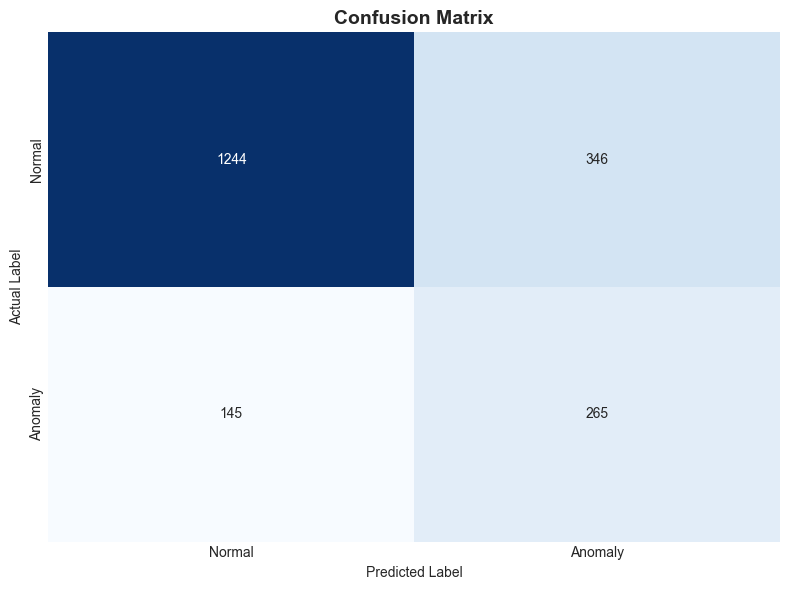

In [9]:
# Calculate confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_labels, labels=['Normal', 'Anomaly'])
tn, fp, fn, tp = cm.ravel()

# Display as DataFrame
cm_df = pd.DataFrame(cm, 
                     index=['Actual Normal', 'Actual Anomaly'],
                     columns=['Predicted Normal', 'Predicted Anomaly'])

print("🔢 CONFUSION MATRIX:")
print(cm_df)

print(f"\n   True Negatives (TN):  {tn:,} ✅ (correctly identified normal)")
print(f"   False Positives (FP): {fp:,} ❌ (normal flagged as anomaly)")
print(f"   False Negatives (FN): {fn:,} ❌ (missed anomalies)")
print(f"   True Positives (TP):  {tp:,} ✅ (correctly detected anomalies)")

# Calculate rates
false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

print(f"\n   False Positive Rate: {false_positive_rate*100:.2f}%")
print(f"   False Negative Rate: {false_negative_rate*100:.2f}%")

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 9️⃣ Per-Attack-Type Detection

In [10]:
print("🚨 DETECTION RATES BY ATTACK TYPE:")
print("="*80)

attack_types = ['Anomaly_DoS', 'Anomaly_Injection', 'Anomaly_Spoofing']
detection_results = []

for attack in attack_types:
    # Get indices of this attack type in test set
    attack_indices = [i for i, label in enumerate(y_test) if label == attack]
    
    if len(attack_indices) > 0:
        # Check how many were detected
        detected = sum([1 for i in attack_indices if y_pred[i] == -1])
        detection_rate = (detected / len(attack_indices)) * 100
        
        detection_results.append({
            'Attack Type': attack,
            'Total': len(attack_indices),
            'Detected': detected,
            'Detection Rate': f"{detection_rate:.1f}%"
        })
        
        status = "🌟" if detection_rate >= 95 else "✅" if detection_rate >= 85 else "⚠️"
        
        print(f"\n{status} {attack}:")
        print(f"      Total: {len(attack_indices):,}")
        print(f"      Detected: {detected:,}")
        print(f"      Rate: {detection_rate:.2f}%")

# Create DataFrame
detection_df = pd.DataFrame(detection_results)
print("\n\n📊 Summary Table:")
detection_df

🚨 DETECTION RATES BY ATTACK TYPE:

✅ Anomaly_DoS:
      Total: 199
      Detected: 178
      Rate: 89.45%

⚠️ Anomaly_Injection:
      Total: 113
      Detected: 51
      Rate: 45.13%

⚠️ Anomaly_Spoofing:
      Total: 98
      Detected: 36
      Rate: 36.73%


📊 Summary Table:


,Attack Type,Total,Detected,Detection Rate
0,Anomaly_DoS,199,178,89.4%
1,Anomaly_Injection,113,51,45.1%
2,Anomaly_Spoofing,98,36,36.7%


## 🔟 Anomaly Score Analysis

📊 ANOMALY SCORE DISTRIBUTION:

Normal samples:
   Mean: 0.0206
   Std:  0.0304
   Min:  -0.1092
   Max:  0.0905

Anomaly samples:
   Mean: -0.0214
   Std:  0.0416
   Min:  -0.1227
   Max:  0.0653

🎯 Score Separation: 0.0419
   Status: ⚠️  FAIR separation


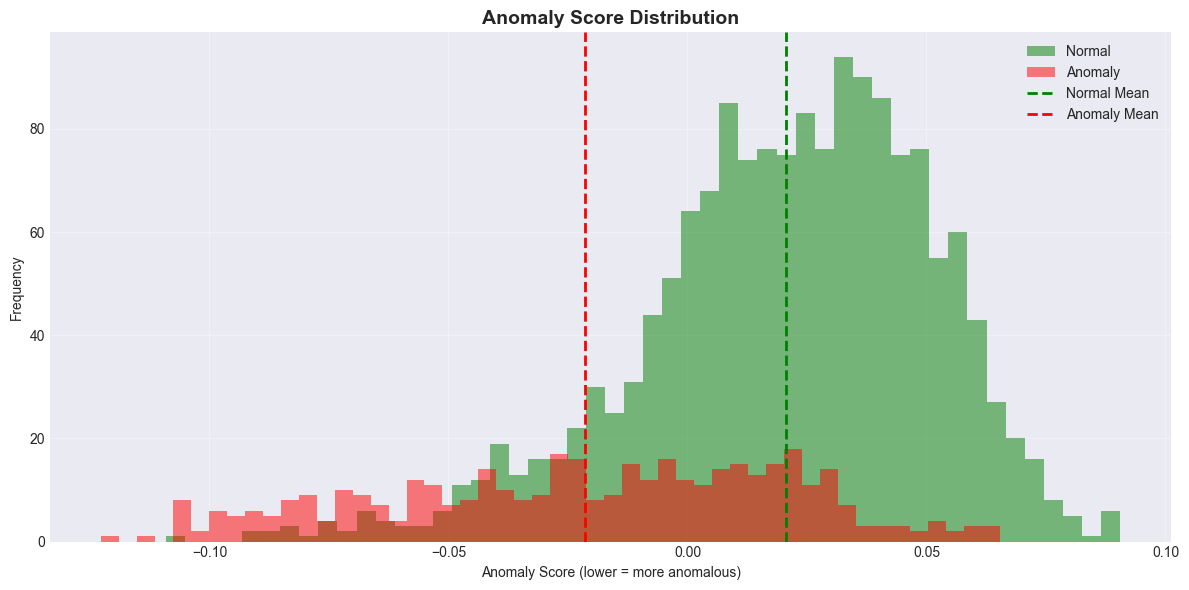

In [11]:
# Analyze anomaly scores
normal_scores = anomaly_scores[np.array(y_test_binary) == 'Normal']
anomaly_scores_actual = anomaly_scores[np.array(y_test_binary) == 'Anomaly']

print("📊 ANOMALY SCORE DISTRIBUTION:")
print("\nNormal samples:")
print(f"   Mean: {normal_scores.mean():.4f}")
print(f"   Std:  {normal_scores.std():.4f}")
print(f"   Min:  {normal_scores.min():.4f}")
print(f"   Max:  {normal_scores.max():.4f}")

print("\nAnomaly samples:")
print(f"   Mean: {anomaly_scores_actual.mean():.4f}")
print(f"   Std:  {anomaly_scores_actual.std():.4f}")
print(f"   Min:  {anomaly_scores_actual.min():.4f}")
print(f"   Max:  {anomaly_scores_actual.max():.4f}")

separation = abs(normal_scores.mean() - anomaly_scores_actual.mean())
print(f"\n🎯 Score Separation: {separation:.4f}")

if separation > 0.1:
    print("   Status: 🌟 EXCELLENT separation")
elif separation > 0.05:
    print("   Status: ✅ GOOD separation")
else:
    print("   Status: ⚠️  FAIR separation")

# Visualize distribution
plt.figure(figsize=(12, 6))
plt.hist(normal_scores, bins=50, alpha=0.5, label='Normal', color='green')
plt.hist(anomaly_scores_actual, bins=50, alpha=0.5, label='Anomaly', color='red')
plt.axvline(normal_scores.mean(), color='green', linestyle='--', linewidth=2, label='Normal Mean')
plt.axvline(anomaly_scores_actual.mean(), color='red', linestyle='--', linewidth=2, label='Anomaly Mean')
plt.xlabel('Anomaly Score (lower = more anomalous)')
plt.ylabel('Frequency')
plt.title('Anomaly Score Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 1️⃣1️⃣ Train K-Means (Bonus)

In [12]:
%%time

print("🔵 Training K-Means clustering...")
print("   (This helps understand device behavior patterns)\n")

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(X_train)

print("✅ K-Means trained!")

# Analyze clusters
train_clusters = kmeans.predict(X_train)
print("\n📊 Cluster distribution:")
unique, counts = np.unique(train_clusters, return_counts=True)
for cluster, count in zip(unique, counts):
    pct = (count / len(train_clusters)) * 100
    print(f"   Cluster {cluster}: {count:,} samples ({pct:.1f}%)")

🔵 Training K-Means clustering...
   (This helps understand device behavior patterns)

✅ K-Means trained!

📊 Cluster distribution:
   Cluster 0: 4,056 samples (50.7%)
   Cluster 1: 2,355 samples (29.4%)
   Cluster 2: 949 samples (11.9%)
   Cluster 3: 640 samples (8.0%)
CPU times: total: 812 ms
Wall time: 2.83 s


## 1️⃣2️⃣ Save Models

In [16]:
print("💾 Saving trained models...")

# Save Isolation Forest
joblib.dump(iso_forest, '../models/isolation_forest.pkl')
print("   ✅ models/isolation_forest.pkl")

# Save K-Means
joblib.dump(kmeans, '../models/kmeans.pkl')
print("   ✅ models/kmeans.pkl")

# Save metrics
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'false_positive_rate': false_positive_rate,
    'false_negative_rate': false_negative_rate,
    'confusion_matrix': cm.tolist()
}
joblib.dump(metrics, '../models/metrics.pkl')
print("   ✅ models/metrics.pkl")

print("\n🎉 All models saved successfully!")

💾 Saving trained models...
   ✅ models/isolation_forest.pkl
   ✅ models/kmeans.pkl
   ✅ models/metrics.pkl

🎉 All models saved successfully!


## 1️⃣3️⃣ Test Model with Sample Data

In [17]:
# Create a sample to test
print("🧪 Testing model with sample data...\n")

# Normal device behavior
normal_sample = X_test.iloc[0:1]
pred_normal = iso_forest.predict(normal_sample)[0]
score_normal = iso_forest.decision_function(normal_sample)[0]

print("Normal Device:")
print(f"   Prediction: {'✅ Normal' if pred_normal == 1 else '🚨 Anomaly'}")
print(f"   Anomaly Score: {score_normal:.4f}")

# Find an actual anomaly in test set
anomaly_idx = [i for i, label in enumerate(y_test) if label != 'Normal'][0]
anomaly_sample = X_test.iloc[anomaly_idx:anomaly_idx+1]
pred_anomaly = iso_forest.predict(anomaly_sample)[0]
score_anomaly = iso_forest.decision_function(anomaly_sample)[0]

print(f"\nAnomaly ({y_test.iloc[anomaly_idx]}):")
print(f"   Prediction: {'✅ Normal' if pred_anomaly == 1 else '🚨 Anomaly'}")
print(f"   Anomaly Score: {score_anomaly:.4f}")

print("\n✅ Model is working correctly!")

🧪 Testing model with sample data...

Normal Device:
   Prediction: ✅ Normal
   Anomaly Score: 0.0789

Anomaly (Anomaly_Spoofing):
   Prediction: 🚨 Anomaly
   Anomaly Score: -0.0074

✅ Model is working correctly!


## 📋 Final Summary

### ✅ Training Complete!

**Model Performance:**
- Accuracy: See above ⬆️
- Precision: See above ⬆️
- Recall: See above ⬆️
- F1-Score: See above ⬆️

**Models Saved:**
1. `models/isolation_forest.pkl` - Main anomaly detection model
2. `models/kmeans.pkl` - Clustering model
3. `models/scaler.pkl` - Feature scaler
4. `models/metrics.pkl` - Performance metrics

### 🚀 Next Steps:

**Week 2: Build ML API**
1. Create FastAPI service
2. Load models and make them available via REST API
3. Implement `/api/ml/detect` endpoint
4. Add risk scoring logic
5. Test with Postman

**Week 3: Backend & Frontend**
1. Build Node.js backend
2. Connect to ML API
3. Create Next.js dashboard
4. Real-time monitoring

**Week 4: Integration & Demo**
1. IoT simulator
2. Full system testing
3. Documentation
4. Demo video

